#Introduction

.....


Check to see if jupyter lab uses the correct python interpreter with '!which python'.
It should be something like '/opt/anaconda3/envs/[environment name]/bin/python' (on Mac).
If not, try this: https://github.com/jupyter/notebook/issues/3146#issuecomment-352718675

In [1]:
!which python

/home/tobi/anaconda3/envs/Assignment5/bin/python


# Install dependencies:

In [2]:
install_packages = True
if install_packages:
    !conda install tensorflow=2 -y
    !conda install -c anaconda pandas -y
    !conda install -c conda-forge tensorflow-hub -y
    !conda install -c conda-forge html2text -y
    !conda install -c conda-forge tqdm -y
    !conda install -c anaconda scikit-learn -y
    !conda install -c conda-forge matplotlib -y
    !conda install -c anaconda seaborn -y

Solving environment: done

## Package Plan ##

  environment location: /home/tobi/anaconda3/envs/Assignment5

  added / updated specs:
    - tensorflow=2


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.10.14 |                0         121 KB
    openssl-1.1.1h             |       h7b6447c_0         2.5 MB
    ------------------------------------------------------------
                                           Total:         2.7 MB

The following packages will be UPDATED:

  certifi                anaconda::certifi-2020.6.20-py36_0 --> pkgs/main::certifi-2020.11.8-py36h06a4308_0

The following packages will be SUPERSEDED by a higher-priority channel:

  ca-certificates                                  anaconda --> pkgs/main
  openssl                                          anaconda --> pkgs/main



ca-certificates-2020 | 121 KB    | ##############################

# Imports

In [3]:
#imports
import pandas as pd
import numpy as np
import os
import time
import tensorflow as tf
import tensorflow_hub as hub
import zipfile
from html2text import HTML2Text
from tqdm import tqdm
import re
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import seaborn as sns

# Set pandas print options
This will improve readability of printed pandas dataframe.


In [4]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Set global Parameters
Set your parameters here:

data_path: In this path put the data you have downloaded with YouTube Data Tools. 
output_path: Tghe files generated in this notebook will be saved here.

url_dict: URLs to models on Tensorflow hub are saved here. Other models are available there.
model_type: Define which model you would like to use. Choose one from url_dict

new_embeddings: If this is true, new embeddings will be generated and saved at output_path. Otherwise, embeddings are loaded from Disc.




In [9]:
data_path = './Documents/FU Berlin/CSMA/Assignment 5/videoinfo_S7Lu-R4EwQw_2020_11_27-16_51_29_comments.tab'
output_path = "./Documents/FU Berlin/CSMA/Assignment 5/output/"

new_embeddings = True

url_dict = {
            'Transformer' : "https://tfhub.dev/google/universal-sentence-encoder-large/5",
            'DAN' : "https://tfhub.dev/google/universal-sentence-encoder/4",
            'Transformer_Multilingual': "https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3"
}

model_type = 'Transformer' #@param ['DAN','Transformer','Transformer_Multilingual']

## Create output directory
Try to create the directory defined by output_path

In [10]:
try:
   os.mkdir(output_path)
except OSError:
  print ("Creation of the directory %s failed" % output_path)
else:
  print ("Successfully created the directory %s " % output_path)


Successfully created the directory ./Documents/FU Berlin/CSMA/Assignment 5/output/ 


# Load Data
Load you data as a pandas dataframe

In [11]:
if new_embeddings:
    data = pd.read_csv(data_path,sep='\t',header=(0))
    data.head()

# Preprocessing
Preprocess your data:
- Drop empty rows
- Drop unused columns

In [12]:
if new_embeddings:
    data = data.dropna(subset=['text', 'authorName']) # drop rows with no content
    data=data.drop(['id', 'replyCount','likeCount','authorChannelUrl','authorChannelId','isReplyTo','isReplyToName'],axis=1) # drop unused columns
    data.head()

- remove HTML-tags, links and usernames

In [13]:
if new_embeddings:
    # Remove HTML tags
    tqdm.pandas()
    h = HTML2Text()
    h.ignore_links = True
    data['cleaned'] = data['text'].progress_apply(lambda x: h.handle(x))
    print( "Removed HTML Tags.")

    # Remove links
    http_link_pattern = r'http\S+'
    bitly_link_pattern = r'bit.ly/\S+'
    data['cleaned'] = data['cleaned'].str.replace(http_link_pattern, '')
    data['cleaned'] = data['cleaned'].str.replace(bitly_link_pattern, '')
    print( "Removed Links.")

    # Remove user names
    keep_names = ["earth", "Tide", "Geologist", "A Person", "Titanic", "adventure", "Sun", "The United States Of America"] # user names we want to keep
    user_names = [name for name in data['authorName'].unique() if (len(name)> 3 and name not in keep_names)]
    data['cleaned'] = data['cleaned'].str.replace('|'.join(map(re.escape, user_names)), '')
    print( "Removed user names.")

100%|██████████| 1337/1337 [00:00<00:00, 5919.41it/s]


Removed HTML Tags.
Removed Links.
Removed user names.


# Save or Load preprocessed data

Save your data afte preprocessing, or load preprocessed data from disc.

In [14]:
if new_embeddings:
  data.to_pickle(output_path+'data_preprocessed'+'.pkl')
else:
  data = pd.read_pickle(output_path+'data_preprocessed'+'.pkl')
data.head()

,publishedAt,authorName,text,isReply,cleaned
0,2020-11-25 12:24:11,polish osaka,Comedian,0,Comedian\n\n
1,2020-11-24 23:45:42,Greg Gilbert,Science isn&#39;t a narrative repeated over &amp; over and climate change denial is a news narrative designed for politics. One issue we should be talking about on the news is the complexity of fixing the problem. The measures they are doing now are pointless. The world is going to have to raise the price of carbon energy equally across the globe so new clean energy takes over. Subsidies won&#39;t work and neither will cherry picking regulations. Carbon energy has to get expensive so the market will solve the problem.,0,Science isn't a narrative repeated over & over and climate change denial is a\nnews narrative designed for politics. One issue we should be talking about on\nthe news is the complexity of fixing the problem. The measures they are doing\nnow are pointless. The world is going to have to raise the price of carbon\nenergy equally across the globe so new clean energy takes over. Subsidies\nwon't work and neither cherry picking regulations. Carbon energy has to\nget expensive so the market solve the problem.\n\n
2,2020-11-23 05:31:36,Benjamin,They&#39;re just creating there own problems,0,They're just creating there own problems\n\n
3,2020-11-16 01:36:35,Tarun Paul,I think the denial is because of economic reasons...,0,I think the denial is because of economic reasons...\n\n
4,2020-11-04 12:53:07,Teafuse,Dangerous people who doesnt believe.... its sad how the world is ending,0,Dangerous people who doesnt believe.... its sad how the world is ending\n\n


# Produce Text Embeddings with Universal Sentence Encoder

## Load Model
Load the model from TF-hub

In [15]:
hub_url = url_dict[model_type]
if new_embeddings:
  print("Loading model. This will take some time...")
  embed = hub.load(hub_url)

Loading model. This will take some time...


## Embed Documents
Produce embeddings of your documents.

In [16]:
if new_embeddings:
    for k,g in data.groupby(np.arange(len(data))//100):
        if k == 0:
            embeddings = embed(g['cleaned'])
        else:
            embeddings_new = embed(g['cleaned'])
            embeddings = tf.concat(values=[embeddings,embeddings_new],axis = 0)
            print(k , end =" ")
    print("The embeddings vector is of fixed length {}".format(embeddings.shape[1]))

    np.save(output_path+'/embeddings'+model_type+'.npy', embeddings, allow_pickle=True, fix_imports=True)
else:
    embeddings = np.load(output_path+'/embeddings'+model_type+'.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

embeddings.shape

1 2 3 4 5 6 7 8 9 10 11 12 13 The embeddings vector is of fixed length 512


TensorShape([1337, 512])

## Calculate Similarity Matrix with angular distance

'Following Cer et al. (2018), we first compute
the sentence embeddings u, v for an STS sentence
pair, and then score the sentence pair similarity
based on the angular distance between the two
embedding vectors  d = − arccos (uv/||u|| ||v||).'

In [17]:
from sklearn.metrics.pairwise import cosine_similarity
def cos_sim(input_vectors):
    similarity = cosine_similarity(input_vectors)
    return similarity
cosine_similarity_matrix = cos_sim(np.array(embeddings))
print(cosine_similarity_matrix)

[[ 1.0000004   0.03351146  0.04322014 ...  0.05074039  0.17345093
  -0.04136358]
 [ 0.03351146  1.0000001   0.03777311 ...  0.3887917   0.05732219
   0.42658204]
 [ 0.04322014  0.03777311  1.0000001  ...  0.00187206  0.1306017
   0.03999752]
 ...
 [ 0.05074039  0.3887917   0.00187206 ...  1.          0.14267156
   0.5393227 ]
 [ 0.17345093  0.05732219  0.1306017  ...  0.14267156  1.0000001
   0.0309487 ]
 [-0.04136358  0.42658204  0.03999752 ...  0.5393227   0.0309487
   0.9999998 ]]


# Plots Similarity 
Plot and print a heat map showing the semantic contextual similarity between comments.

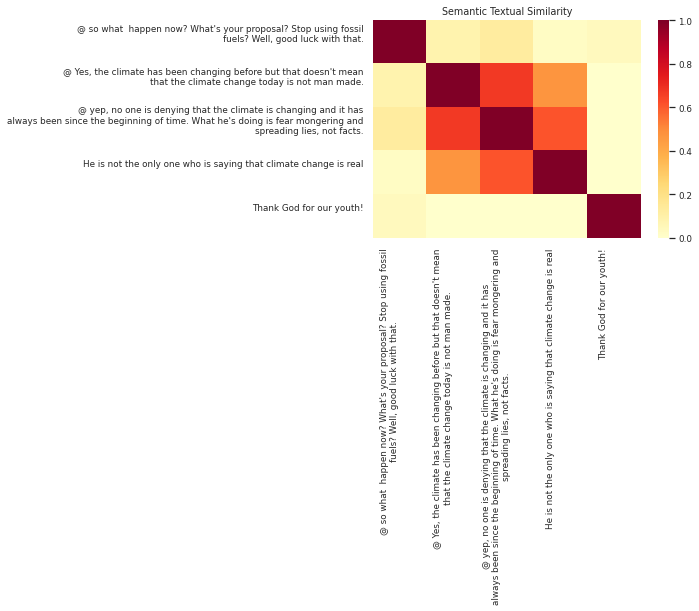

In [68]:
import seaborn as sns
def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=0.8)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

num_samples = 5
off_set = 375

plot_similarity(data.iloc[off_set:off_set+num_samples]['cleaned'], embeddings[off_set:off_set+num_samples], 90)

# Show neighbours of a comment 
Define which comment to analyze

In [69]:
comment_index = 375
comment = data["cleaned"][comment_index]
comment_list = data["cleaned"].tolist()
print(comment)

@ so what  happen now? What's your proposal? Stop using fossil
fuels? Well, good luck with that.




Print similar comments.

In [70]:
def get_top_similar(sentence, sentence_list, similarity_matrix, topN):
    # find the index of sentence in list
    index = sentence_list.index(sentence)
    # get the corresponding row in similarity matrix
    similarity_row = np.array(similarity_matrix[index, :])
    # get the indices of top similar
    indices = similarity_row.argsort()[-topN:][::-1]
    return [sentence_list[i] for i in indices]


for i, value in enumerate(get_top_similar(comment, comment_list, cosine_similarity_matrix, 20)):
  print("Top similar comment {}: {}".format(i+1, value))

Top similar comment 1: @ so what  happen now? What's your proposal? Stop using fossil
fuels? Well, good luck with that.


Top similar comment 2: @ So what are these plans and how're we to execute
them?


Top similar comment 3: @ Aren't you vomiting, then how you  be able to understand
anything. It is quite clear this is not the first time you are rejecting based
on nonsense.


Top similar comment 4: @ Now you chicken out, what a way to prove yourself right. gg


Top similar comment 5: @ So you just basically go away? LOL how incompetent


Top similar comment 6: @ Also, you forgot to discuss the practicality of
these so called plans that you've yet to give.


Top similar comment 7: And since I can tell you  go on and on with your drivel, you can have the
last word on this. Good night.


Top similar comment 8: @ Yup ! And when your predictions fail, your hypothesis fails too.


Top similar comment 9: also I don't even know what you're talking about, you've made no points for me
to avoid.